# Regrid pft output to grids per variable and pft (intermediate postprocessing step) 


(c) Inne Vanderkelen - October 2023

## 1. Settings

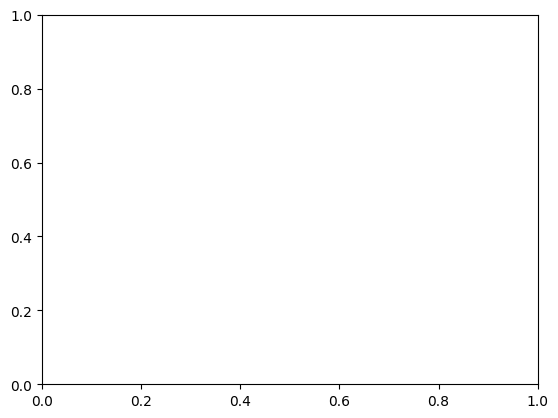

In [2]:
# laod modules 
import xarray as xr
import matplotlib.pyplot as plt
import os
import regionmask 

# import own utils module
from iv_utils_daint import *
from ctsm_py.utils import * #info on ctsm utils: https://github.com/NCAR/ctsm_python_gllery 

# do plotting settings
set_plot_param()

# ignore all runtime warnings
warnings.filterwarnings('ignore')

In [3]:
# directory settings

# set directories
outdir = '/scratch/snx3000/ivanderk/'

# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 

# go to processing directory 
os.chdir(procdir)

In [4]:
# case settings

# define scenario
scenario = '4p1000'

# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup2.nophs'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup2.nophs'

case   = case_ctl
block  = 'lnd' 
stream = 'h1' 

# List of variables to import from file(s) in $indir matching $pattern.
variables = ["SOILLIQ", 'H2OSOI',"TOTSOILLIQ","TOTSOILICE", "QINFL" ,"QOVER", "QDRAI", 'EFLX_LH_TOT',  "watsat","QROOTSINK" ,"QVEGE", "QVEGT","QSOIL",
             "watfc",  "SMP",  "patches1d_itype_veg"]           

# discard 2004 until 2008 as spin up years
start_year, end_year = 1990, 2014 # 2028 

time_slice = slice(str(start_year)+"-01-01", str(end_year)+"-12-31")

In [5]:
# get pfts modelled - bare soil, grassland and crop pfts
pft_list = [0,12,13,14,15,16]

In [6]:
# calculate saturated fraction
def calc_and_safe_saturated_fraction(pft_list, case): 
    for pft_int in pft_list: 

        print('processing pft '+str(pft_int))

        da_h2soi = load_da_gridded_pft('H2OSOI', pft_int, case).rename('H2OSOI').rename({'ivt_str':'pft'})
        da_watsat = load_da_gridded_pft('watsat', pft_int, case)
        da_watsat = da_watsat.rename('watsat').rename({'ivt_str':'pft'}).rename({'levgrnd':'levsoi'}).isel(levsoi=range(0,20))

        da_satfrac = (da_h2soi/da_watsat).rename('satfrac').assign_attrs({'units':'-','long_name':'saturated fraction'})

        del da_watsat, da_h2soi

        ds_gridded = xr.Dataset()

        ds_gridded['satfrac_'+str(pft_int)] = da_satfrac

        ds_gridded.to_netcdf(procdir+'/postprocessing/pft_gridding/'+'satfrac'+'_'+str(pft_int)+'.'+case+'.nc')

        del ds_gridded    

In [7]:
# get pfts modelled - bare soil, grassland and crop pfts
pft_list = [15]

## Regrid scenario and control case

In [ ]:
%%time
ds_ctl = import_case(case_ctl, myVars=variables,  myVegtypes=pft_list, timeSlice=time_slice, stream=stream, alter_lons=False)

In [18]:
%%time
grid_multiple_pfts_multiple_vars(ds_ctl, variables,  pft_list, case_ctl)

processing variable SOILLIQ
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/SOILLIQ_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup2.nophs.nc
processing variable patches1d_itype_veg
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/patches1d_itype_veg_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup2.nophs.nc
CPU times: user 43.6 s, sys: 27.9 s, total: 1min 11s
Wall time: 1min 24s


In [8]:
%%time
ds_scen = import_case(case_scen, myVars=variables,  myVegtypes=pft_list, timeSlice=time_slice, stream=stream, alter_lons=False)

CPU times: user 1min 13s, sys: 24.2 s, total: 1min 37s
Wall time: 2min 16s


In [9]:
variables = ["QOVER", "QDRAI", 'EFLX_LH_TOT',  "watsat","QROOTSINK" ,"QVEGE", "QVEGT","QSOIL",
             "watfc",  "SMP",  "patches1d_itype_veg"]      

In [10]:
%%time
grid_multiple_pfts_multiple_vars(ds_scen, variables,  pft_list, case_scen)

processing variable QOVER
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/QOVER_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.4p1000.spunup2.nophs.nc
processing variable QDRAI
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/QDRAI_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.4p1000.spunup2.nophs.nc
processing variable EFLX_LH_TOT
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/EFLX_LH_TOT_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.4p1000.spunup2.nophs.nc
processing variable watsat
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/watsat_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.4p1000.spunup2.nophs.nc
processing variable QROOTSINK
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/QROOTSINK_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.4p1000.spunup2.nophs.nc
processing variable QVEGE
process

## Cst Soil resistance

In [18]:
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.cstsoilres'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.cstsoilres'

# List of variables to import from file(s) in $indir matching $pattern.
variables = ["SOILLIQ", "TOTSOILLIQ", "QINFL" ,"QOVER", "QDRAI", 'EFLX_LH_TOT', "QVEGE", "QVEGT","SMP",  "patches1d_itype_veg"]           

# discard 2004 until 2008 as spin up years
start_year, end_year = 1990, 2014 # 2028 

time_slice = slice(str(start_year)+"-01-01", str(end_year)+"-12-31")

In [19]:
%%time
ds_scen = import_case(case_scen, myVars=variables,  myVegtypes=pft_list, timeSlice=time_slice, stream=stream, alter_lons=False)

CPU times: user 1min 11s, sys: 20.4 s, total: 1min 32s
Wall time: 1min 56s


In [20]:
%%time
grid_multiple_pfts_multiple_vars(ds_scen, variables,  pft_list, case_scen)

processing variable SOILLIQ
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/SOILLIQ_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.4p1000.cstsoilres.nc
processing variable TOTSOILLIQ
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/TOTSOILLIQ_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.4p1000.cstsoilres.nc
processing variable QINFL
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/QINFL_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.4p1000.cstsoilres.nc
processing variable QOVER
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/QOVER_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.4p1000.cstsoilres.nc
processing variable QDRAI
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/QDRAI_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.4p1000.cstsoilres.nc
processing variable EFLX_LH_TOT
processing pft 15
/scrat

In [21]:
%%time
ds_ctl = import_case(case_ctl, myVars=variables,  myVegtypes=pft_list, timeSlice=time_slice, stream=stream, alter_lons=False)

CPU times: user 1min 12s, sys: 20.5 s, total: 1min 32s
Wall time: 2min


In [22]:
%%time
grid_multiple_pfts_multiple_vars(ds_ctl, variables,  pft_list, case_ctl)

processing variable SOILLIQ
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/SOILLIQ_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.cstsoilres.nc
processing variable TOTSOILLIQ
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/TOTSOILLIQ_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.cstsoilres.nc
processing variable QINFL
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/QINFL_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.cstsoilres.nc
processing variable QOVER
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/QOVER_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.cstsoilres.nc
processing variable QDRAI
processing pft 15
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/QDRAI_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.cstsoilres.nc
processing variable EFLX_LH_TOT
processing pft 15
/scratch/snx3000/ivan